# Explore here

In [13]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import requests
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
response = requests.get(url).content.decode('utf-8')

file_name = '../data/raw/diabetes.csv'

with open(file_name, 'w') as temp_file:
    temp_file.writelines(response)

In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
df = pd.read_csv(file_name)
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
#Buscamos registros duplicados, no hay.
print(df.duplicated().sum())

0


In [6]:
#Obtenemos los valores únicos para averiguar si hay columnas que puedan ser binarias, no las hay, solo el outcome.
pd.set_option('display.max_rows', None,)
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [7]:
# No hay que factorizar, todas las columnas son numéricas

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# No hay valores null
pd.set_option('display.max_rows', None,)
df.isnull().mean()*100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

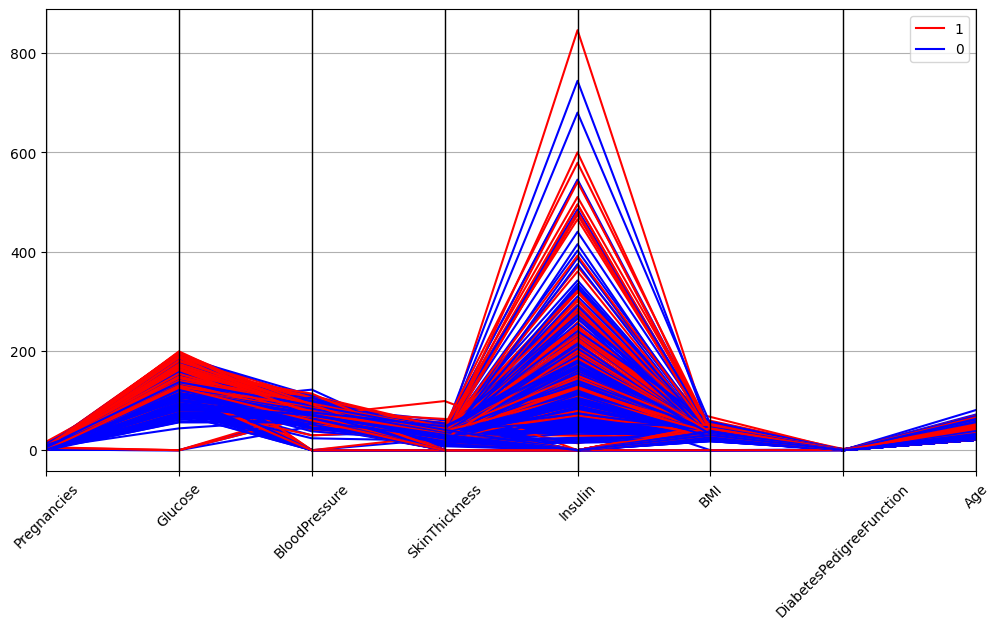

In [15]:
# Ploteamos los datos

plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

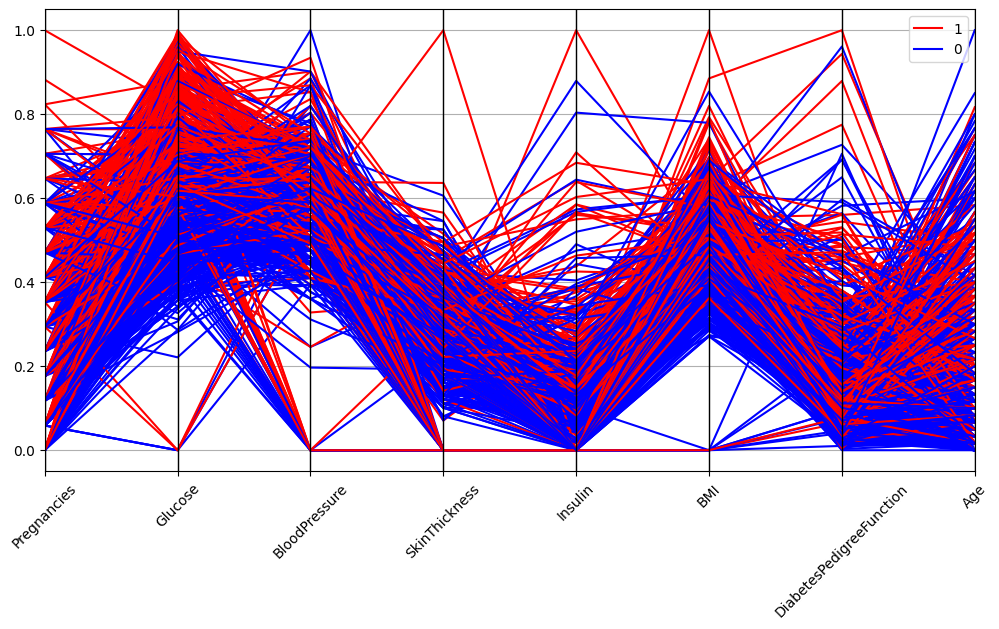

In [25]:
# Procedemos a escalar el dataframe

df_sc = pd.DataFrame(data=MinMaxScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df.Outcome
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [27]:
#Separamos la variable dependiente de las independientes (y las variables no factorizadas) con el nuevo dataframe 
X = df_sc.drop(['Outcome'], axis=1)
y = df_sc['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Creamos un árbol complejo y uno simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42).fit(X_train, y_train)
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42).fit(X_train, y_train)

# Aplicamos los árboles sobre los datos de entrenamiento y de test
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [29]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [30]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
Test,0.746753,0.672269,0.742424,0.625,0.727273,0.757576
Diferencia,0.253247,0.327731,0.257576,0.375,0.272727,0.242424


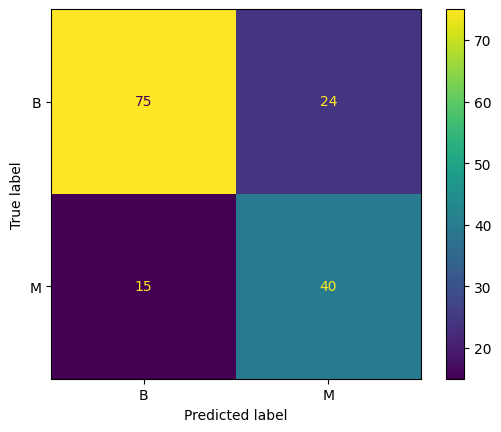

In [38]:
cm = confusion_matrix(y_test, test_pred_complex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [31]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.737785,0.663883,0.739823,0.597744,0.746479,0.733167
Test,0.636364,0.594203,0.660606,0.493976,0.745455,0.575758
Diferencia,0.101421,0.069680,0.079217,0.103768,0.001024,0.157410


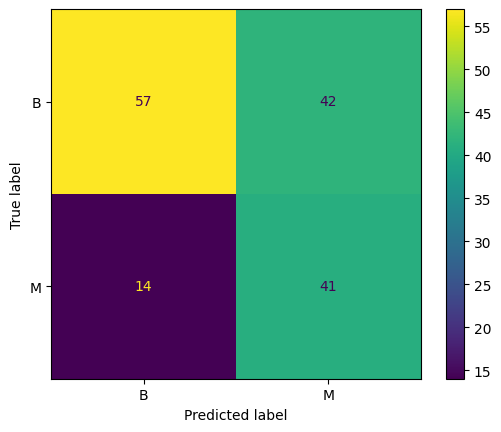

In [32]:
cm = confusion_matrix(y_test, test_pred_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [33]:
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Age <= 0.13
|   |--- Glucose <= 0.64
|   |   |--- BMI <= 0.46
|   |   |   |--- class: 0
|   |   |--- BMI >  0.46
|   |   |   |--- class: 0
|   |--- Glucose >  0.64
|   |   |--- SkinThickness <= 0.32
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  0.32
|   |   |   |--- class: 1
|--- Age >  0.13
|   |--- BMI <= 0.42
|   |   |--- Glucose <= 0.62
|   |   |   |--- class: 0
|   |   |--- Glucose >  0.62
|   |   |   |--- class: 0
|   |--- BMI >  0.42
|   |   |--- Insulin <= 0.17
|   |   |   |--- class: 1
|   |   |--- Insulin >  0.17
|   |   |   |--- class: 1



In [34]:
text_representation = export_text(complex_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Glucose <= 0.64
|   |--- Age <= 0.13
|   |   |--- BMI <= 0.46
|   |   |   |--- DiabetesPedigreeFunction <= 0.25
|   |   |   |   |--- class: 0
|   |   |   |--- DiabetesPedigreeFunction >  0.25
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.26
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- DiabetesPedigreeFunction >  0.26
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  0.46
|   |   |   |--- BloodPressure <= 0.30
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  0.30
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.18
|   |   |   |   |   |--- SkinThickness <= 0.09
|   |   |   |   |   |   |--- Glucose <= 0.55
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Glucose >  0.55
|   |   |   |   |   |   |   |--- Glucose <= 0.62
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Glucose >  0.62
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- SkinThickness >  0.09
|   |   |   |   |   |   

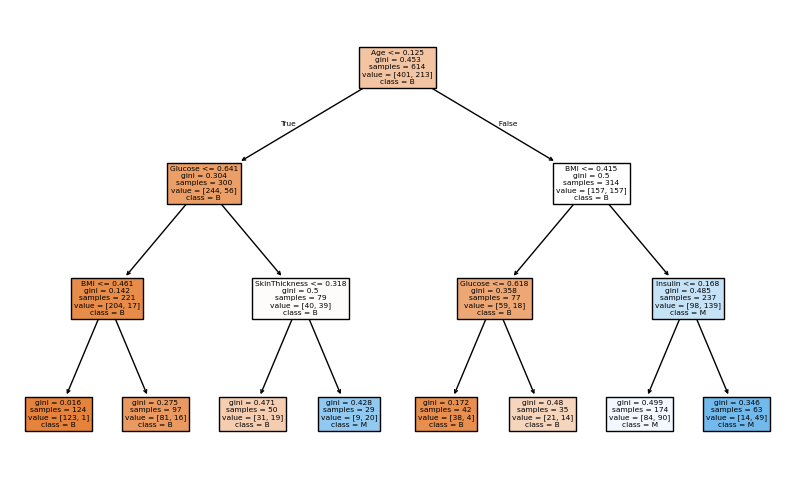

In [35]:
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['B','M'], filled=True)
plt.show()

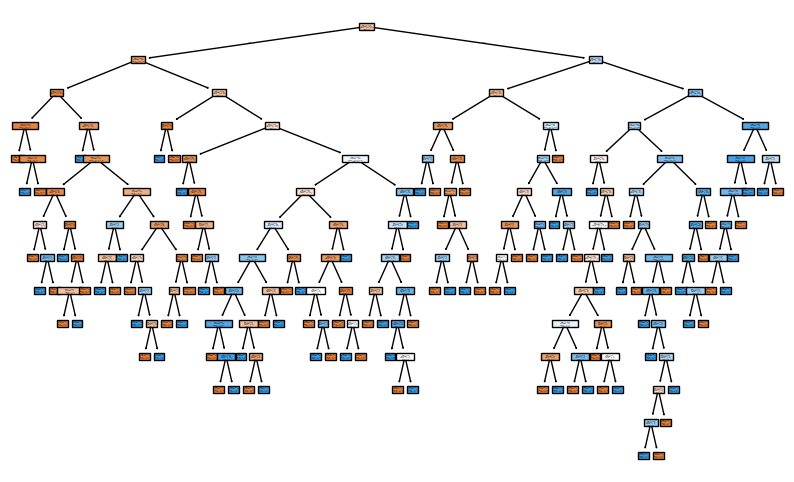

In [36]:
plt.figure(figsize=(10, 6))
plot_tree(complex_tree, feature_names=X_train.columns, class_names=['B','M'], filled=True)
plt.show()

Podemos observar que en el arbol complejo hay un overfitting evidente, y mucha diferencia en todos los valores de train y test, mientras que en el arbol simple hay muy malos resultados para train y test, así que lo ideal es buscar un punto intermedio

In [89]:
# Creamos un árbol complejo y uno simple
simple_tree_2 = DecisionTreeClassifier(max_depth=20, max_features=X_train.shape[1]//2, min_samples_leaf=10, random_state=42).fit(X_train, y_train)
#complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42).fit(X_train, y_train)

# Aplicamos los árboles sobre los datos de entrenamiento y de test
train_pred_simple_2 = simple_tree_2.predict(X_train)
test_pred_simple_2 = simple_tree_2.predict(X_test)

get_metrics(y_train, y_test, train_pred_simple_2, test_pred_simple_2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.838762,0.754342,0.809426,0.800000,0.713615,0.905237
Test,0.714286,0.576923,0.676768,0.612245,0.545455,0.808081
Diferencia,0.124477,0.177419,0.132658,0.187755,0.168160,0.097156


El max_depth de 20 a 100 apenas modifica las métricas, al igual que el max_features, que todas, a la mitad, apenas modifica el resultado si el resto de valores son iguales, sin embargo el min_samples_leaf es clave para mejorar el resultado de train, pero no tanto de test, encontrando el 10 el punto a partir del cual empiezan a empeorar las diferencias entre train y test, ya que solo mejora train generando cada vez más overfitting.